In [2]:
import pickle
import glob
import sys
import os
import time
import cPickle as pickle
import numpy as np
import theano
import theano.tensor as T
from IPython.display import Image as IPImage
from PIL import Image
import lasagne
import matplotlib.pyplot as plt

from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

from lasagne.layers import Conv2DLayer as Conv2DLayer
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayer

%matplotlib inline

In [3]:
NUM_EPOCHS = 500
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 32
NUM_CLASSES = 10
cifar_npz = "cifar10.npz"

#Retrieve CIFAR 10
#get_ipython().system(u'wget -N https://s3.amazonaws.com/lasagne/recipes/pretrained/cifar10/cifar10.npz')

In [4]:
def load_cifar10(dirpath='cifar-10-batches-py'):
    # load training data
    X, y = [], []
    for path in glob.glob('%s/data_batch_*' % dirpath):
        with open(path, 'rb') as f:
            batch = pickle.load(f)
        X.append(batch['data'])
        y.append(batch['labels'])
    X = np.concatenate(X) \
          .reshape(-1, 3, 32, 32) \
          .astype(np.float32)
    y = np.concatenate(y).astype(np.int32)
    # split into training and validation sets
    ii = np.random.permutation(len(X))
    X_train = X[ii[1000:]]
    y_train = y[ii[1000:]]
    X_valid = X[ii[:1000]]
    y_valid = y[ii[:1000]]
    # load test set
    path = '%s/test_batch' % dirpath
    with open(path, 'rb') as f:
        batch = pickle.load(f)
    X_test = batch['data'] \
             .reshape(-1, 3, 32, 32) \
             .astype(np.float32)
    y_test = np.array(batch['labels'], dtype=np.int32)
    # normalize to zero mean and unity variance
    offset = np.mean(X_train, 0)
    scale = np.std(X_train, 0).clip(min=1)
    X_train = (X_train - offset) / scale
    X_valid = (X_valid - offset) / scale
    X_test = (X_test - offset) / scale
    return X_train, y_train, X_valid, y_valid, X_test, y_test



3


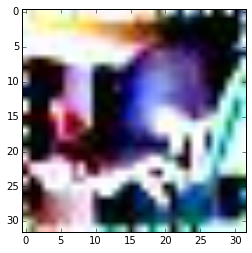

In [6]:
def get_picture_array(X, index, shp=(DIM,DIM),channels=3):
    ret = ((X[index]+0.5)*255.).reshape(channels,shp[0],shp[1]) \
        .transpose(2,1,0).clip(0,255).astype(np.uint8)
    if channels == 1:
        ret=ret.reshape(shp[1],shp[0])
    return ret


def get_image(X,channels=3,idx=-1):
    mode = 'RGB' if channels == 3 else 'L'
    index = prng.randint(X.shape[0]) if idx == -1 else idx
    shp=X[0][0].shape
    image = Image.fromarray(get_picture_array(X, index,shp,channels),mode=mode)
    return image

X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print y_train[15070]

get_image(X_train,channels=3,idx=15070).save('frame.jpg')

photo = plt.imread('frame.jpg')
plt.imshow(photo) 


In [59]:
def build_cnn(input_var=None):
    
    conv_num_filters = 16
    filter_size = 3
    pool_size = 2
    encode_size = 16
    dense_mid_size = 128
    pad_in = 'valid'
    pad_out = 'full'

    # Input layer, as usual:                                                                                                                                                                                
    network = InputLayer(shape=(None, 3, 32, 32),
                                        input_var=input_var,name="InputLayer_0")                                                                                                                                   
    network = Conv2DLayer(
            network, num_filters=conv_num_filters, filter_size=(filter_size, filter_size),pad=pad_in,name = "Conv2DLayer_1")
    
    network = Conv2DLayer(
            network, num_filters=conv_num_filters, filter_size=(filter_size, filter_size),pad=pad_in,name = "Conv2DLayer_2")
                                                                                                                                        
    network = MaxPool2DLayer(network, pool_size=(pool_size, pool_size),name = "MaxPool2DLayer_3")
                                                                                                                                     
    network = Conv2DLayer(
            network, num_filters=2*conv_num_filters, filter_size=(filter_size, filter_size),pad=pad_in,name = "Conv2DLayer_4")

    network = MaxPool2DLayer(network, pool_size=(pool_size, pool_size),name = "MaxPool2DLayer_5")

    network = ReshapeLayer(network, shape=(([0], -1)),name = "ReshapeLayer_6")
    
    network = DenseLayer(network,num_units=dense_mid_size,name = "dense_mid_7")
    
    network = DenseLayer(network,num_units=encode_size,name = "encode")
    
    network = DenseLayer(network,num_units=dense_mid_size,name = "dense_mid_9")
    
    network = DenseLayer(network,num_units=1152,name = "dense_mid_10")
    
    network = ReshapeLayer(network, shape = (([0], 2*conv_num_filters, 6, 6)),name = "ReshapeLayer_11")
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name = "Upscale2DLayer_12")
    
    network = Conv2DLayer(
            network, num_filters=2*conv_num_filters, filter_size=(filter_size, filter_size),pad=pad_out,name = "Conv2DLayer_13")
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name = "Upscale2DLayer_14")
    
    network = Conv2DLayer(
            network, num_filters=conv_num_filters, filter_size=(filter_size, filter_size),pad=pad_out,name = "Conv2DLayer_15")
    
    network = Conv2DLayer(
            network, num_filters=3, filter_size=(filter_size, filter_size),pad=pad_out, name = "Conv2DLayer_16")
    
    network = ReshapeLayer(network, shape=(([0], -1)),name = "ReshapeLayer_17")

    return network


In [60]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def iterator(X, batchsize):
    indices = np.arange(len(X))
    for i in range(0, len(X) - batchsize + 1, batchsize):
        sli = indices[i:i+batchsize]
        yield X[sli]

In [61]:
def save_params(model, fn):
    with open(fn, 'w') as wr:
        pickle.dump(lasagne.layers.get_all_param_values(model), wr)

In [66]:
def main(model='cnn', num_epochs=500):
    # Load the dataset                                                                                                                                                                                      
    print("Loading data...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()

    print('Train data shape: ', X_train.shape)
    print('Train labels shape: ', y_train.shape)
    print('Validation data shape: ', X_val.shape)
    print('Validation labels shape: ', y_val.shape)
    print('Test data shape: ', X_test.shape)
    print('Test labels shape: ', y_test.shape)

    # Prepare Theano variables for inputs and targets                                                                                                                                                       
    input_var = T.tensor4('inputs')
    #target_var = T.ivector('targets')

    # Create neural network model (depending on first command line parameter)                                                                                                                               
    print("Building model and compiling functions...")

    network = build_cnn(input_var)
    laylist = lasagne.layers.get_all_layers(network)
    
    for l in laylist:
        print l.name, lasagne.layers.get_output_shape(l)
        
    # Create a loss expression for training, i.e., a scalar objective we want                                                                                                                               
    # to minimize (for our multi-class problem, it is the cross-entropy loss):                                                                                                                              
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, input_var.flatten(2))
    loss = loss.mean()
    # We could add some weight decay as well here, see lasagne.regularization.                                                                                                                              

    # Create update expressions for training, i.e., how to modify the                                                                                                                                       
    # parameters at each training step. Here, we'll use Stochastic Gradient                                                                                                                                 
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.                                                                                                                                 
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.9)

    # Create a loss expression for validation/testing. The crucial difference                                                                                                                               
    # here is that we do a deterministic forward pass through the network,                                                                                                                                  
    # disabling dropout layers.                                                                                                                                                                             
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.squared_error(test_prediction,
                                                            input_var.flatten(2))
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:                                                                                                                                
    #test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), input_var.flatten(2)),dtype=theano.config.floatX)

    # Compile a function performing a training step on a mini-batch (by giving                                                                                                                              
    # the updates dictionary) and returning the corresponding training loss:                                                                                                                                
    #train_fn = theano.function([input_var, target_var], loss, updates=updates)
    train_fn = theano.function([input_var], loss, updates=updates)
    #out_fn = theano.function([input_var],prediction)
    #loss_fn = theano.function([input_var],loss)
    # Compile a second function computing the validation loss and accuracy:                                                                                                                                 
    #val_fn = theano.function([input_var, target_var], [test_loss, test_acc])
    val_fn = theano.function([input_var], test_loss)
    # Finally, launch the training loop.                                                                                                                                                                    
    print("Starting training...")
    loss_history = []
    # We iterate over epochs:                                                                                                                                                                               
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:                                                                                                                                          
        train_err = 0
        train_batches = 0
        start_time = time.time()
            
        for batch in iterator(X_train, 10):
            train_err += train_fn(batch)
            train_batches += 1
            loss_history.append(train_err)
        
        # And a full pass over the validation data:                                                                                                                                                         
        val_err = 0
        val_acc = 0
        val_batches = 0
        
        for batch in iterator(X_val, 10):
            err = val_fn(batch)
            val_err += err
            val_batches += 1
            

        # Then we print the results for this epoch:                                                                                                                                                         
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        
    # After training, we compute and print the test error:                                                                                                                                                  
    test_err = 0
    test_acc = 0
    test_batches = 0
    for batch in iterator(X_test,500):
        err = val_fn(batch)
        test_err += err
        test_batches += 1
        
    print("Final results:")
    print("  test loss:\t\t\t{:.6f}".format(test_err / test_batches))
    
    # Optionally, you could now dump the network weights to a file like this:                                                                                                                               
    np.savez('model.npz', *lasagne.layers.get_all_param_values(network))                                                                                                                                  
    #                                                                                                                                                                                                       
    # And load them again later on like this:                                                                                                                                                               
    # with np.load('model.npz') as f:                                                                                                                                                                       
    #     param_values = [f['arr_%d' % i] for i in range(len(f.files))]                                                                                                                                     
    # lasagne.layers.set_all_param_values(network, param_values)  


In [67]:
main()

Loading data...
('Train data shape: ', (49000, 3, 32, 32))
('Train labels shape: ', (49000,))
('Validation data shape: ', (1000, 3, 32, 32))
('Validation labels shape: ', (1000,))
('Test data shape: ', (10000, 3, 32, 32))
('Test labels shape: ', (10000,))
Building model and compiling functions...
InputLayer_0 (None, 3, 32, 32)
Conv2DLayer_1 (None, 16, 30, 30)
Conv2DLayer_2 (None, 16, 28, 28)
MaxPool2DLayer_3 (None, 16, 14, 14)
Conv2DLayer_4 (None, 32, 12, 12)
MaxPool2DLayer_5 (None, 32, 6, 6)
ReshapeLayer_6 (None, 1152)
dense_mid_7 (None, 128)
encode (None, 16)
dense_mid_9 (None, 128)
dense_mid_10 (None, 1152)
ReshapeLayer_11 (None, 32, 6, 6)
Upscale2DLayer_12 (None, 32, 12, 12)
Conv2DLayer_13 (None, 32, 14, 14)
Upscale2DLayer_14 (None, 32, 28, 28)
Conv2DLayer_15 (None, 16, 30, 30)
Conv2DLayer_16 (None, 3, 32, 32)
ReshapeLayer_17 (None, 3072)
Starting training...
1.13703882694
2.14672458172
3.52115535736
4.57396495342
5.31710112095
6.06079566479
7.27002191544
8.1385614872
9.23237168789

KeyboardInterrupt: 

In [ ]:
plt.plot(np.array(loss_history).clip(max=3))
plt.xlabel('iteration')
plt.ylabel('loss')